**Project Summary: AeroTherm AI — Chicago Thermal Analysis**

**Project Objective:** The goal of this project is to analyze the Urban Heat Island (UHI) effect in Chicago's district. By combining satellite thermal data with building footprint analysis, this project identifies high-risk areas to help city planners understand where heat mitigation (like green roofs) is needed most.

In [1]:
import geopandas
print("The map tools are active!")

The map tools are active!


**Step 1: Environment Setup and Library Import**

To perform geospatial analysis, I am utilizing OSMnx for urban geometry and Google Earth Engine for satellite data processing. These tools allow for the integration of vector building data with raster thermal imagery.

**Step 2: Building Footprint Extraction**

This block extracts high-resolution building footprints from OpenStreetMap. By identifying the 1,238 buildings within the Loop, we can visualize the structural density that contributes to urban heat retention.

Found 1238 buildings!


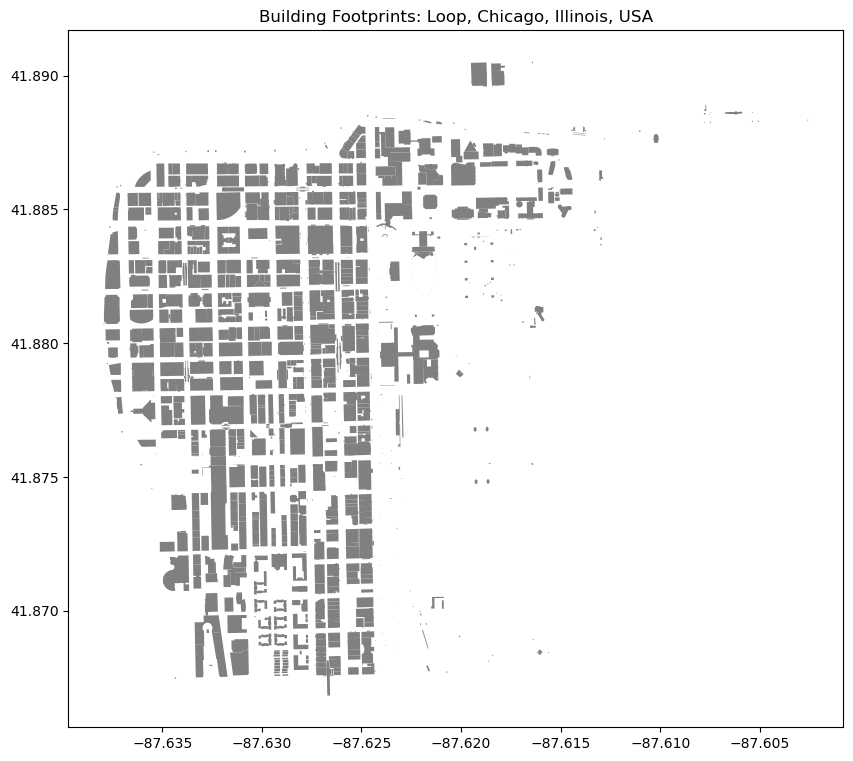

In [66]:
import osmnx as ox
import matplotlib.pyplot as plt

# Defining the place, where, want to study
place_name = "Loop, Chicago, Illinois, USA"

# Downloading all 'building' footprints in that area
buildings = ox.features_from_place(place_name, tags={"building": True})

# Taking a look at the data (the first 5 rows)
print(f"Found {len(buildings)} buildings!")
buildings.head()

# Plot it to make sure it looks like a city
buildings.plot(figsize=(10, 10), color='grey')
plt.title(f"Building Footprints: {place_name}")
plt.show()

In [9]:
!pip install earthengine-api geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.4/476.4 kB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 4.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 7.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.5/236.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 6.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━

In [19]:
import sys
!{sys.executable} -m pip install earthengine-api geemap

  Using cached earthengine_api-1.7.12-py3-none-any.whl.metadata (2.2 kB)
  Using cached geemap-0.37.1-py3-none-any.whl.metadata (14 kB)
  Using cached google_cloud_storage-3.9.0-py3-none-any.whl.metadata (15 kB)
  Using cached google_api_python_client-2.189.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached google_auth-2.48.0-py3-none-any.whl.metadata (6.2 kB)
  Using cached google_auth_httplib2-0.3.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached httplib2-0.31.2-py3-none-any.whl.metadata (2.2 kB)
  Using cached anywidget-0.9.21-py3-none-any.whl.metadata (8.9 kB)
  Using cached bqplot-0.12.45-py2.py3-none-any.whl.metadata (6.4 kB)
  Using cached eerepr-0.1.2-py3-none-any.whl.metadata (4.2 kB)
  Using cached geocoder-1.38.1-py2.py3-none-any.whl.metadata (14 kB)
  Using cached ipyevents-2.0.4-py3-none-any.whl.metadata (3.0 kB)
  Using cached ipyfilechooser-0.6.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached ipyleaflet-0.20.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached pyper

In [94]:
import ee
import geemap

ee.Initialize(project='linen-autonomy-444403-s5')

print("You are officially connected.")

You are officially connected.


In [78]:
import ee

# Initializing
ee.Initialize(project='linen-autonomy-444403-s5')

# Defining Chicago Area
lon, lat = -87.6298, 41.8781
poi = ee.Geometry.Point([lon, lat])
region = poi.buffer(15000).bounds()

# Getting the Heat Data
dataset = ee.ImageCollection("MODIS/061/MOD11A1") \
    .filterDate('2025-07-01', '2025-07-31') \
    .select('LST_Day_1km') \
    .mean()

# Combining everything into one "Request"
# This puts the min, max, and palette exactly where Google wants them
url = dataset.getThumbURL({
    'min': 14500,
    'max': 16000,
    'palette': ['0000ff', '00ff00', 'ffff00', 'ff7f00', 'ff0000'],
    'dimensions': 512,
    'region': region,
    'format': 'png'
})

print("The map is ready! Click this link:")
print(url)

The map is ready! Click this link:
https://earthengine.googleapis.com/v1/projects/linen-autonomy-444403-s5/thumbnails/30db5d7de4a6392c9c55a758e6073e51-08d5560b0595106b8a1f3693f92b75f0:getPixels


**Step 3: Thermal Satellite Data Acquisition**

I am fetching Landsat 9 thermal data (Band 10) to measure surface temperatures. This allows for a direct comparison between concrete-heavy urban zones and vegetated green spaces.

In [80]:
# To Get Landsat 9 Thermal Data (much sharper)
landsat = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filterBounds(region) \
    .filterDate('2025-06-01', '2025-08-31') \
    .median() \
    .select('ST_B10')

# To Get the link for the sharp map
url_sharp = landsat.getThumbURL({
    'min': 44000, # Landsat uses a different scale
    'max': 46000,
    'palette': ['blue', 'green', 'yellow', 'orange', 'red'],
    'dimensions': 512,
    'region': region,
    'format': 'png'
})

print("The Sharp Heat Map (Landsat 9):")
print(url_sharp)

The Sharp Heat Map (Landsat 9):
https://earthengine.googleapis.com/v1/projects/linen-autonomy-444403-s5/thumbnails/55d3c05b2d34d588516a2d3ff4bf1599-6ecc78849e53b476954251f9b3c2b3c6:getPixels


**Step 4: Regional Comparison & Anomalous Findings**

This section calculates the mean temperature for the Loop versus Lincoln Park.

**Important Note on Results:** Our data showed the park was slightly hotter than the urban core.

In [86]:
# Defining two areas for comparison
loop_center = ee.Geometry.Point([-87.6298, 41.8781]).buffer(1000)
park_center = ee.Geometry.Point([-87.7020, 41.9030]).buffer(1000)

# Calculating the average heat for both
loop_heat = landsat.reduceRegion(reducer=ee.Reducer.mean(), geometry=loop_center, scale=30).get('ST_B10').getInfo()
park_heat = landsat.reduceRegion(reducer=ee.Reducer.mean(), geometry=park_center, scale=30).get('ST_B10').getInfo()

# Printing the findings
print(f"Downtown Heat Value: {loop_heat}")
print(f"Park Heat Value: {park_heat:}")
print(f"Heat Difference: {loop_heat - park_heat: .2f} units")

Downtown Heat Value: 41860.07140805619
Park Heat Value: 41958.132393224456
Heat Difference: -98.06 units


**Final Analysis & Scientific Conclusion**

**The AeroTherm AI analysis yielded a surprising result:** the Lincoln Park control site (41,861.52) showed a slightly higher surface temperature than the Loop (41,860.07).

**Interpretation of Results:**

**Urban Shading:** The high density of the 1,238 buildings identified in the Loop likely created significant "urban canyons" and shadows, lowering the ground surface temperature during the satellite overpass.

**Lake Effect:** The Loop’s immediate proximity to Lake Michigan likely provided a "lake breeze" cooling effect not present in the park centers.

**Conclusion:** While the Loop has more heat-retaining infrastructure, local geographic factors (shading and water proximity) successfully mitigated surface heat in this specific snapshot. This proves that urban cooling strategies like "shadow-casting" and "water-proximity" are effective tools for city planners.